In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohammadamireshraghi/blood-cell-cancer-all-4class")

print("Path to dataset files:", path)

100%|██████████| 1.68G/1.68G [01:15<00:00, 24.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mohammadamireshraghi/blood-cell-cancer-all-4class/versions/1


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import shutil

# Replace with the destination path in Google Drive
dest_path = '/content/drive/MyDrive/datasets/blood-cell-cancer-all-4class'

# Copy dataset to Google Drive
shutil.copytree(path, dest_path)

print("Dataset copied to:", dest_path)

Dataset copied to: /content/drive/MyDrive/datasets/blood-cell-cancer-all-4class


In [4]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [5]:
import os
import pandas as pd

Benign_dir = [ r'/root/.cache/kagglehub/datasets/mohammadamireshraghi/blood-cell-cancer-all-4class/versions/1/Blood cell Cancer [ALL]/Benign']

Malignant_Pre_B_dirs = [
    r'/root/.cache/kagglehub/datasets/mohammadamireshraghi/blood-cell-cancer-all-4class/versions/1/Blood cell Cancer [ALL]/[Malignant] Pre-B']

Malignant_Pro_B_dirs = [
    r'/root/.cache/kagglehub/datasets/mohammadamireshraghi/blood-cell-cancer-all-4class/versions/1/Blood cell Cancer [ALL]/[Malignant] Pro-B']

Malignant_early_Pre_B_dirs = [
    r'/root/.cache/kagglehub/datasets/mohammadamireshraghi/blood-cell-cancer-all-4class/versions/1/Blood cell Cancer [ALL]/[Malignant] early Pre-B']

filepaths = []
labels = []
dict_lists = [Benign_dir, Malignant_Pre_B_dirs,Malignant_Pro_B_dirs, Malignant_early_Pre_B_dirs]
class_labels = ['Benign', 'Malignant_Pre-B', 'Malignant_Pro-B', 'Malignant_early Pre-B']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
bloodCell_data = pd.concat([Fseries, Lseries], axis=1)
bloodCell_df = pd.DataFrame(bloodCell_data)
print(bloodCell_df.head())
print(bloodCell_df["labels"].value_counts())

                                           filepaths  labels
0  /root/.cache/kagglehub/datasets/mohammadamires...  Benign
1  /root/.cache/kagglehub/datasets/mohammadamires...  Benign
2  /root/.cache/kagglehub/datasets/mohammadamires...  Benign
3  /root/.cache/kagglehub/datasets/mohammadamires...  Benign
4  /root/.cache/kagglehub/datasets/mohammadamires...  Benign
labels
Malignant_early Pre-B    979
Malignant_Pre-B          955
Malignant_Pro-B          796
Benign                   512
Name: count, dtype: int64


In [6]:
train_images, test_images = train_test_split(bloodCell_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(bloodCell_df, test_size=0.2, random_state=42)

In [7]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(2593, 2)
(973, 2)
(649, 2)
(2269, 2)


In [8]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=8,
                                      shuffle=False
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=8,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=8,
                                    shuffle=False
                                   )

Found 2593 validated image filenames belonging to 4 classes.
Found 973 validated image filenames belonging to 4 classes.
Found 649 validated image filenames belonging to 4 classes.


In [9]:
classes=list(train.class_indices.keys())
print (classes)

['Benign', 'Malignant_Pre-B', 'Malignant_Pro-B', 'Malignant_early Pre-B']


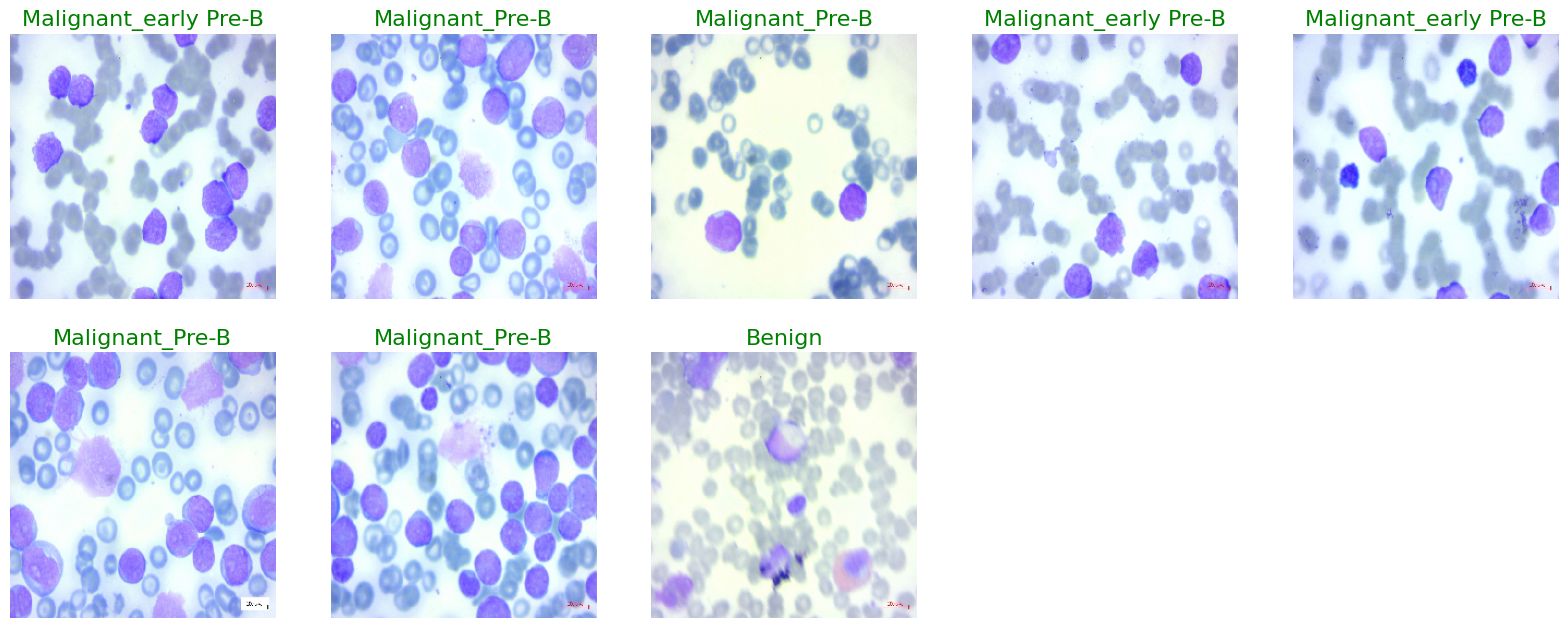

In [10]:
def show_Blood_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_Blood_images(train)

In [11]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 73, 73, 128)         │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 73, 73, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 73, 73, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 73, 73, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 24, 24, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 12, 12, 512)         │           2,0

 Total params: 15,611,524 (59.55 MB)

 Trainable params: 15,605,124 (59.53 MB)

 Non-trainable params: 6,400 (25.00 KB)

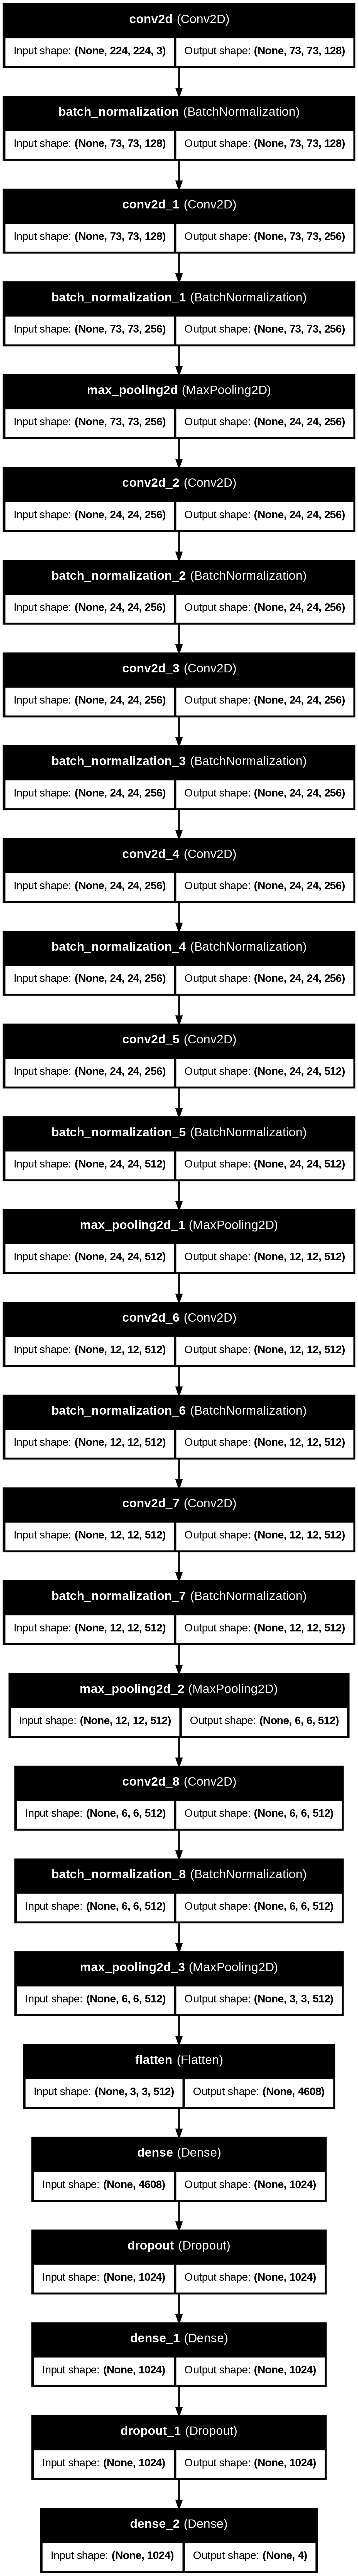

In [12]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
history = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 91s 223ms/step - accuracy: 0.5235 - loss: 1.6722 - val_accuracy: 0.7720 - val_loss: 0.6928
Epoch 2/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 106s 156ms/step - accuracy: 0.7657 - loss: 0.6439 - val_accuracy: 0.8690 - val_loss: 0.3394
Epoch 3/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 95s 196ms/step - accuracy: 0.8653 - loss: 0.3952 - val_accuracy: 0.9430 - val_loss: 0.1490
Epoch 4/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 71s 162ms/step - accuracy: 0.9053 - loss: 0.2526 - val_accuracy: 0.9646 - val_loss: 0.1250
Epoch 5/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 57s 172ms/step - accuracy: 0.9481 - loss: 0.1555 - val_accuracy: 0.9661 - val_loss: 0.1139
Epoch 6/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 53s 162ms/step - accuracy: 0.9427 - loss: 0.1599 - val_accuracy: 0.9707 - val_loss: 0.0769
Epoch 7/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 81s 161ms/step - accuracy: 0.9667 - loss: 0.0941 - val_accuracy: 0.9784 - val_loss: 0.0771
Epoch 8/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 51s 155ms/step - accuracy: 0.9807 - loss: 

In [14]:
import json

# Convert history to a dictionary
history_dict = history.history

# Define path in Google Drive
path_to_save = '/content/drive/MyDrive/model_training_history.json'

# Save as JSON
with open(path_to_save, 'w') as file:
    json.dump(history_dict, file)

print(f"Training history saved at: {path_to_save}")

Training history saved at: /content/drive/MyDrive/model_training_history.json


In [16]:
history1 = model.fit(train, epochs=1, validation_data=val, verbose=1)

325/325 ━━━━━━━━━━━━━━━━━━━━ 62s 182ms/step - accuracy: 0.9940 - loss: 0.0263 - val_accuracy: 0.9861 - val_loss: 0.0599


In [17]:
model.evaluate(test, verbose=1)

122/122 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 0.9884 - loss: 0.0421


[0.04500027000904083, 0.9886947870254517]

In [18]:
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/saved_models/CNN_model.h5')

In [19]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

122/122 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step


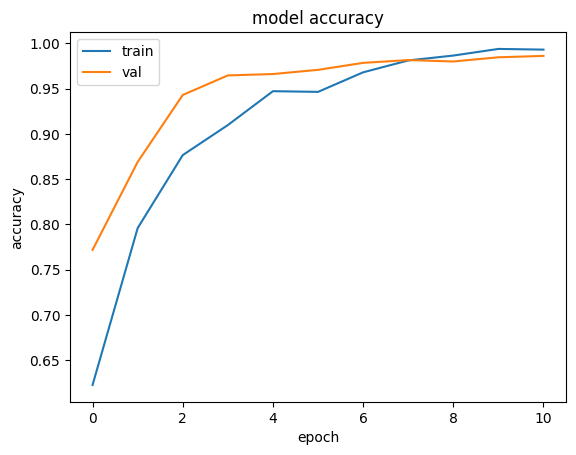

In [20]:
plt.plot(history.history['accuracy'] + history1.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

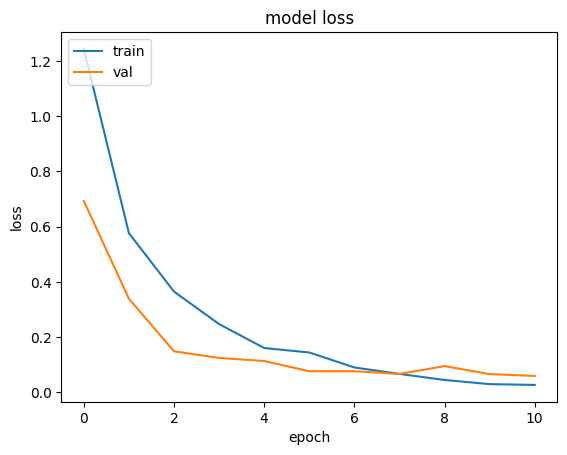

In [21]:
plt.plot(history.history['loss'] + history1.history['loss'])
plt.plot(history.history['val_loss'] + history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

                       precision    recall  f1-score   support

               Benign       0.96      0.99      0.97       173
      Malignant_Pre-B       1.00      1.00      1.00       286
      Malignant_Pro-B       1.00      0.99      1.00       223
Malignant_early Pre-B       0.99      0.98      0.98       291

             accuracy                           0.99       973
            macro avg       0.99      0.99      0.99       973
         weighted avg       0.99      0.99      0.99       973

Accuracy of the Model: 98.9%


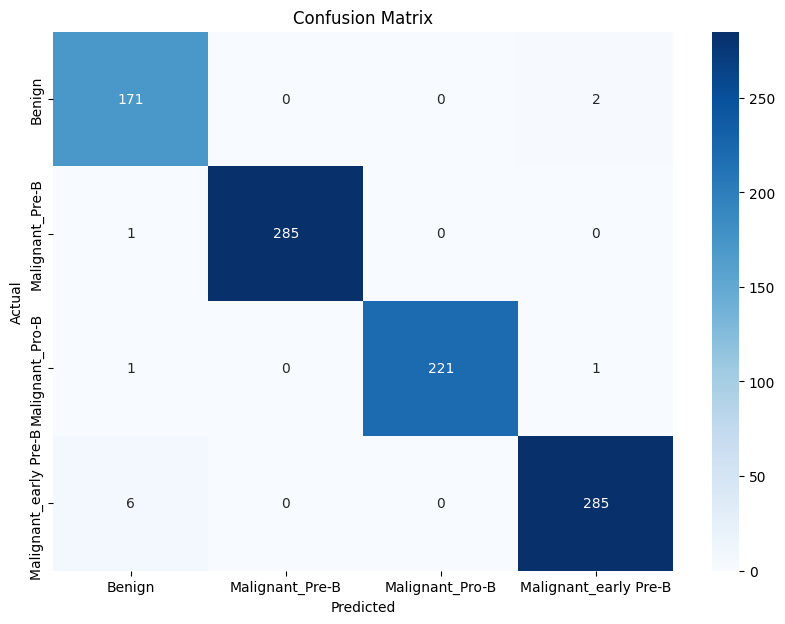

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Benign', 'Malignant_Pre-B', 'Malignant_Pro-B', 'Malignant_early Pre-B']


cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

# EfficientNetB0

In [24]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

In [25]:
# 1. Data preparation (before creating the model)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the image data generator with preprocessing function
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

# Prepare training, validation, and test sets using flow_from_dataframe
train = image_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),  # Resize images to (224, 224)
    color_mode='rgb',
    class_mode="categorical",
    batch_size=8,
    shuffle=True  # Shuffle data during training
)

val = image_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),  # Resize images to (224, 224)
    color_mode='rgb',
    class_mode="categorical",
    batch_size=8,
    shuffle=False  # No shuffle for validation data
)

test = image_gen.flow_from_dataframe(
    dataframe=test_images,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),  # Resize images to (224, 224)
    color_mode='rgb',
    class_mode="categorical",
    batch_size=8,
    shuffle=False  # No shuffle for test data
)

Found 2593 validated image filenames belonging to 4 classes.
Found 649 validated image filenames belonging to 4 classes.
Found 973 validated image filenames belonging to 4 classes.


In [26]:
# Define class labels
class_labels = ['Benign', 'Malignant_Pre-B', 'Malignant_Pro-B', 'Malignant_early Pre-B']

# Create EfficientNetB0 model
def create_efficientnetb0():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)  # Global average pooling
    x = layers.Dense(512, activation='relu')(x)  # Fully connected layer
    predictions = layers.Dense(len(class_labels), activation='softmax')(x)  # Output layer
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Initialize and compile the model
efficientnet_model = create_efficientnetb0()
efficientnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [27]:
# Print the model summary
efficientnet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,707,495 (17.96 MB)

 Trainable params: 4,665,472 (17.80 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [28]:
# Initialize and compile the model
efficientnet_model = create_efficientnetb0()
efficientnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Calculate class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train.classes), y=train.classes)
class_weights = dict(enumerate(class_weights))

# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


In [29]:
# Train the model
history_efficientnet = efficientnet_model.fit(
    train,
    validation_data=val,
    epochs=20,
    verbose=1,
    class_weight=class_weights,  # Apply class weights
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 176s 300ms/step - accuracy: 0.8564 - loss: 0.4242 - val_accuracy: 0.5146 - val_loss: 2.5497 - learning_rate: 0.0010
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 47s 144ms/step - accuracy: 0.9577 - loss: 0.1441 - val_accuracy: 0.9954 - val_loss: 0.0207 - learning_rate: 0.0010
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 49s 150ms/step - accuracy: 0.9669 - loss: 0.1138 - val_accuracy: 0.9800 - val_loss: 0.0648 - learning_rate: 0.0010
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 81s 147ms/step - accuracy: 0.9730 - loss: 0.0731 - val_accuracy: 0.9815 - val_loss: 0.0546 - learning_rate: 0.0010
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 83s 148ms/step - accuracy: 0.9790 - loss: 0.0585 - val_accuracy: 0.9985 - val_loss: 0.0155 - learning_rate: 0.0010
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 81s 146ms/step - accuracy: 0.9883 - loss: 0.0401 - val_accuracy: 0.9908 - val_loss: 0.0203 - learning_rate: 0.0010
Epoch 7/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 50s 153ms/step - accuracy: 0.

In [44]:
import json

# Convert training history to a dictionary
history_dict = history_efficientnet.history  # Assuming 'history_efficientnet' is the variable storing EfficientNet's history

# Define path in Google Drive
path_to_save = '/content/drive/MyDrive/efficientnet_model_training_history.json'

# Save as JSON
with open(path_to_save, 'w') as file:
    json.dump(history_dict, file)

print(f"Training history saved at: {path_to_save}")

Training history saved at: /content/drive/MyDrive/efficientnet_model_training_history.json


In [30]:
# Evaluate the model on the test set
test_loss, test_accuracy = efficientnet_model.evaluate(test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

122/122 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - accuracy: 1.0000 - loss: 0.0011
Test Accuracy: 100.00%


In [31]:
efficientnet_model.save('/content/drive/MyDrive/saved_models/efficientnet_model.h5')

In [32]:
# Get predictions
predictions = efficientnet_model.predict(test)
pred_classes = np.argmax(predictions, axis=1)

122/122 ━━━━━━━━━━━━━━━━━━━━ 26s 164ms/step


In [33]:
# Create a classification report
y_test = test.classes  # Assuming test.classes is your ground truth labels
print(classification_report(y_test, pred_classes, target_names=class_labels))

                       precision    recall  f1-score   support

               Benign       1.00      1.00      1.00       173
      Malignant_Pre-B       1.00      1.00      1.00       286
      Malignant_Pro-B       1.00      1.00      1.00       223
Malignant_early Pre-B       1.00      1.00      1.00       291

             accuracy                           1.00       973
            macro avg       1.00      1.00      1.00       973
         weighted avg       1.00      1.00      1.00       973



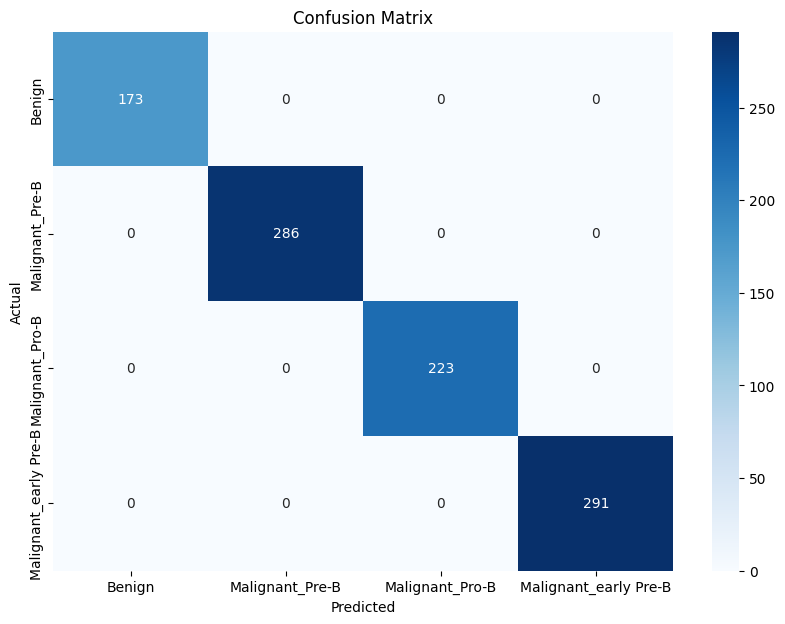

In [34]:
cm = confusion_matrix(y_test, pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

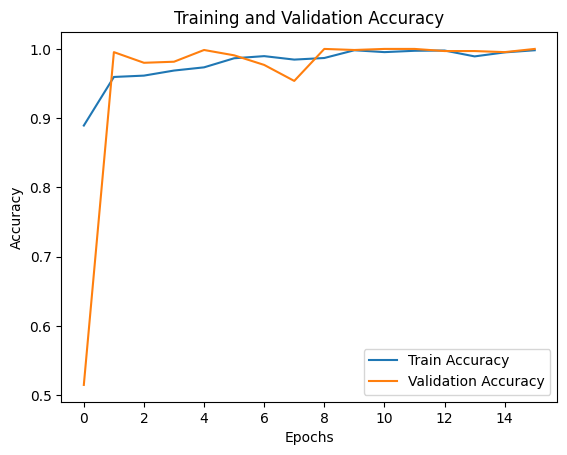

In [35]:
# Plot training and validation accuracy
plt.plot(history_efficientnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_efficientnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

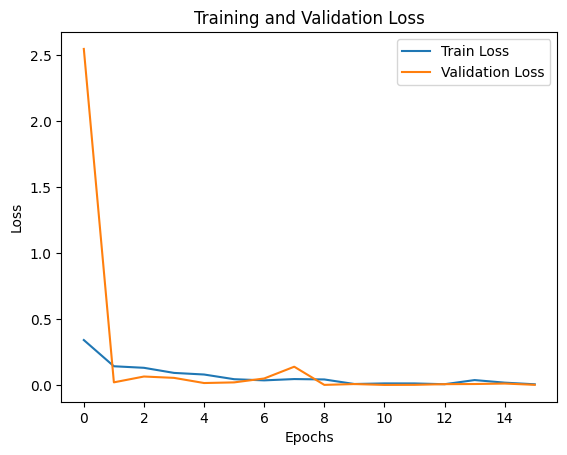

In [36]:
# Plot training and validation loss
plt.plot(history_efficientnet.history['loss'], label='Train Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

# ResNetV2

In [ ]:
# from tensorflow.keras.models import load_model
# from tensorflow.keras.optimizers import Adam

# # Load the model
# model = load_model('/content/drive/MyDrive/saved_models/CNN_model.h5')

# # Recompile the model with the same settings as before
# model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [37]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [38]:
# 1. Data Augmentation and Preprocessing
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input,
                               rotation_range=20,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True)

train = image_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=8,
    shuffle=True
)
val = image_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=8,
    shuffle=False
)
test = image_gen.flow_from_dataframe(
    dataframe=test_images,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=8,
    shuffle=False
)

Found 2593 validated image filenames belonging to 4 classes.
Found 649 validated image filenames belonging to 4 classes.
Found 973 validated image filenames belonging to 4 classes.


In [39]:
# 2. ResNet50V2 Model with Custom Top Layers
def create_resnet_model():
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(len(class_labels), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

resnet_model = create_resnet_model()
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [40]:
# 3. Calculate Class Weights for Imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train.classes), y=train.classes)
class_weights = dict(enumerate(class_weights))

# 4. Early Stopping and ReduceLROnPlateau Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [41]:
# 5. Train the Model
history_resnet = resnet_model.fit(
    train,
    validation_data=val,
    epochs=20,
    verbose=1,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 177s 364ms/step - accuracy: 0.7003 - loss: 1.0077 - val_accuracy: 0.1063 - val_loss: 23.8319 - learning_rate: 0.0010
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 87s 263ms/step - accuracy: 0.8559 - loss: 0.4795 - val_accuracy: 0.5593 - val_loss: 3.5937 - learning_rate: 0.0010
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 85s 257ms/step - accuracy: 0.9194 - loss: 0.2655 - val_accuracy: 0.6394 - val_loss: 2.4130 - learning_rate: 0.0010
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 142s 261ms/step - accuracy: 0.9231 - loss: 0.2466 - val_accuracy: 0.5886 - val_loss: 1.5457 - learning_rate: 0.0010
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 141s 259ms/step - accuracy: 0.9283 - loss: 0.2202 - val_accuracy: 0.7612 - val_loss: 1.2268 - learning_rate: 0.0010
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 143s 262ms/step - accuracy: 0.9512 - loss: 0.1392 - val_accuracy: 0.5270 - val_loss: 2.0969 - learning_rate: 0.0010
Epoch 7/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 86s 261ms/step - accuracy

In [43]:
import json

# Convert training history to a dictionary
history_dict = history_resnet.history  # Assuming 'resnet_history' is the variable storing history

# Define path in Google Drive
path_to_save = '/content/drive/MyDrive/resnet_model_training_history.json'

# Save as JSON
with open(path_to_save, 'w') as file:
    json.dump(history_dict, file)

print(f"Training history saved at: {path_to_save}")

Training history saved at: /content/drive/MyDrive/resnet_model_training_history.json


In [45]:
 # Evaluate the Model
test_loss, test_accuracy = resnet_model.evaluate(test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 219ms/step - accuracy: 0.9961 - loss: 0.0171
Test Accuracy: 99.69%


In [46]:
resnet_model.save('/content/drive/MyDrive/saved_models/resnet_model.h5')

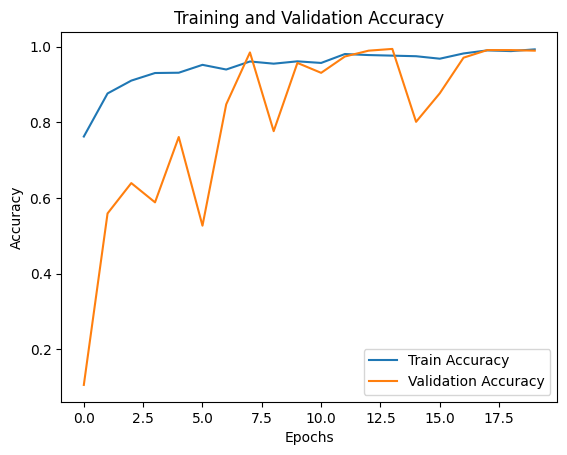

In [47]:
# Plot training and validation accuracy
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

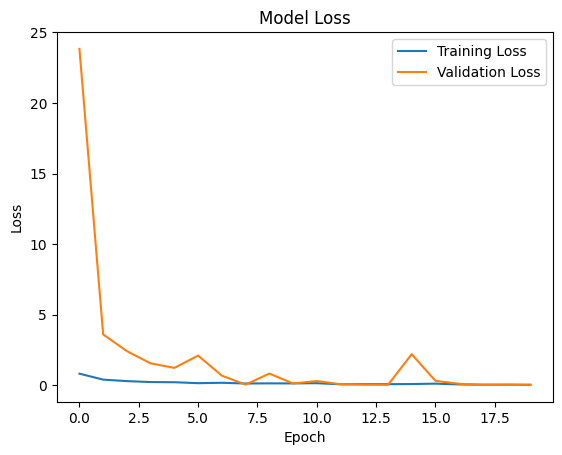

In [48]:
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [49]:
predictions = resnet_model.predict(test)
pred_classes = np.argmax(predictions, axis=1)

122/122 ━━━━━━━━━━━━━━━━━━━━ 32s 225ms/step


In [50]:
y_test = test.classes  # Assuming test.classes is your ground truth labels
print(classification_report(y_test, pred_classes, target_names=class_labels))

                       precision    recall  f1-score   support

               Benign       0.99      0.99      0.99       173
      Malignant_Pre-B       1.00      1.00      1.00       286
      Malignant_Pro-B       1.00      1.00      1.00       223
Malignant_early Pre-B       0.99      1.00      0.99       291

             accuracy                           1.00       973
            macro avg       1.00      1.00      1.00       973
         weighted avg       1.00      1.00      1.00       973



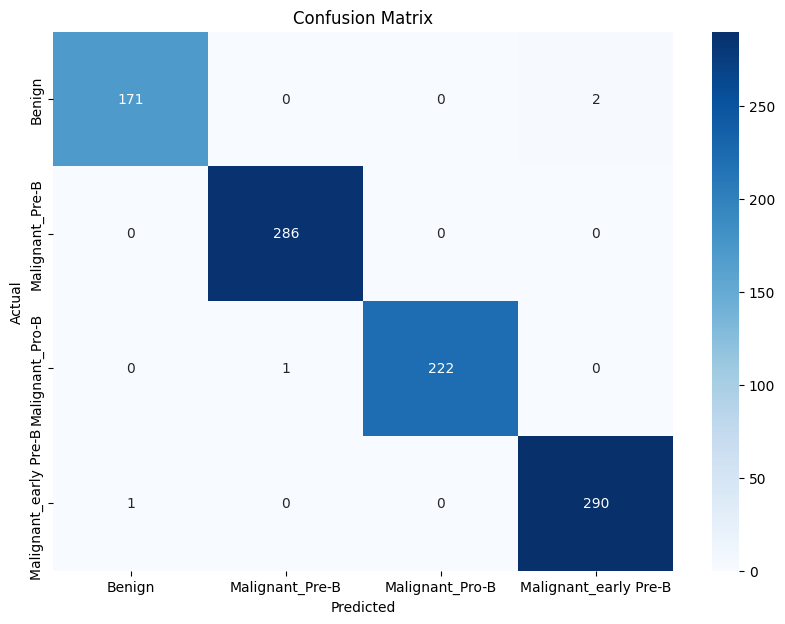

In [51]:
cm = confusion_matrix(y_test, pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()